In [45]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [46]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [47]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, MetaData, Table, Column, ForeignKey

Base = automap_base()

In [48]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [49]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
#engine.tablenames()

In [50]:
# x = metadata.reflect(engine)
#for item in metadata.tables:
 #   print(item)
Base.classes.keys()

['measurement', 'station']

In [51]:
# View all of the classes that automap found
from sqlalchemy import inspect
inspector = inspect(engine)
schemas = inspector.get_schema_names()

for schema in schemas:
    print("schema: %s" % schema)
    for table_name in inspector.get_table_names(schema=schema):
        for column in inspector.get_columns(table_name, schema=schema):
            print("Column: %s" % column['name'])

schema: main
Column: id
Column: station
Column: date
Column: prcp
Column: tobs
Column: id
Column: station
Column: name
Column: latitude
Column: longitude
Column: elevation


In [52]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [53]:
# Create our session (link) from Python to the DB
session = Session(engine)

#  Precipitation Analysis

In [54]:
# Earliest Date
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [55]:
# Latest Date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
latest_date

'2017-08-23'

In [56]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_twelve_months = dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)
last_twelve_months

datetime.datetime(2016, 8, 23, 0, 0)

In [57]:
# Calculate the date one year from the last date in data set.
last_twelve_months = dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)
last_twelve_months

datetime.datetime(2016, 8, 23, 0, 0)

In [58]:
# Perform a query to retrieve the data and precipitation scores
# Calculate the date one year from the last date in data set.
p_results = session.query(Measurement.date, func.avg(Measurement.prcp)).\
                    filter(Measurement.date >= last_twelve_months).\
                    group_by(Measurement.date).all()

In [59]:
# Put data into dataframe
precipitation_df = pd.DataFrame(p_results, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date', inplace=True)
precipitation_df.head()

,Precipitation
Date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


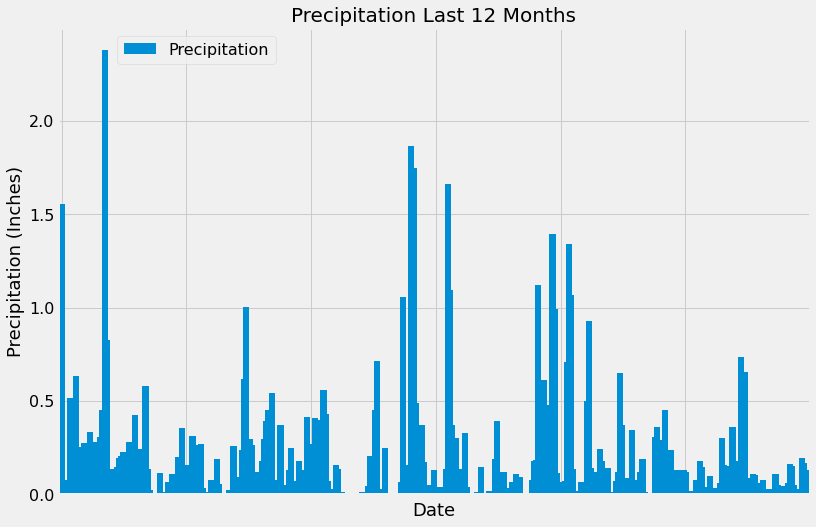

In [60]:
# Plot the precipitation for the past 12 months
ax = precipitation_df.plot(kind='bar', width=3, figsize=(12,8))
plt.locator_params(axis='x', nbins=6)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.tick_params(axis='y', labelsize=16)
ax.grid(True)
plt.legend(bbox_to_anchor=(.3,1), fontsize="16")
plt.title("Precipitation Last 12 Months", size=20)
plt.ylabel("Precipitation (Inches)", size=18)
plt.xlabel("Date", size=18)
#plt.savefig("")
plt.show()

In [61]:
# Print the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


#  Station Analysis

In [62]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count()

9

In [63]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
s_results = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
s_results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [64]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#set the most active station
best_station = s_results[0][0]
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == best_station).all()

[(54.0, 71.66378066378067, 85.0)]

In [65]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#query for the last year of temperature data
best_station = s_results[0][0]

session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == best_station).all()


[(54.0, 71.66378066378067, 85.0)]

In [66]:
t_results = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == best_station).\
                filter(Measurement.date >= last_twelve_months).all()
tobs_df = pd.DataFrame(t_results)
tobs_df.set_index('station', inplace=True)
tobs_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0
USC00519281,73.0


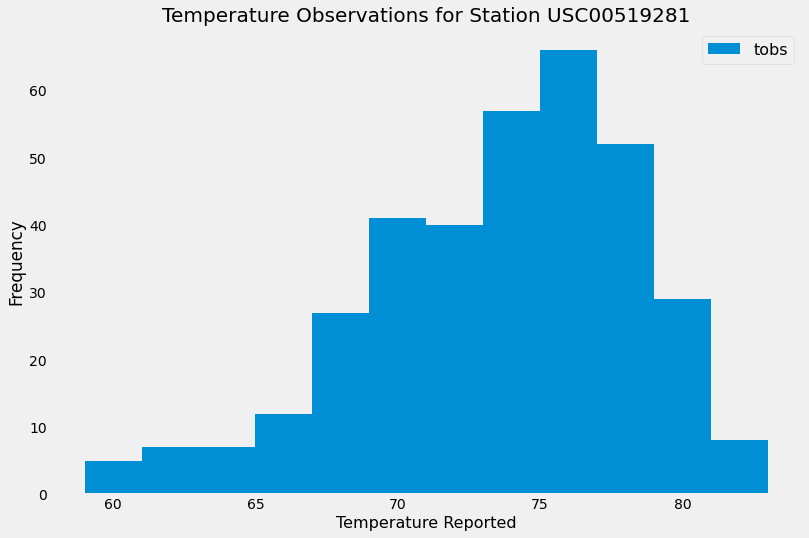

In [67]:
# Plot the results as a histogram with bins=12.
tobs_df.plot.hist(by='station', bins=12, figsize=(12,8))
plt.grid()
plt.title("Temperature Observations for Station " + best_station, fontsize=20)
plt.xlabel("Temperature Reported", fontsize=16)
plt.legend(bbox_to_anchor=(1,1), fontsize=16)
#plt.savefig(".png")
plt.show()

# Close session

In [68]:
# Close Session
session.close()